In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_val_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(
    train_val_dataset, [train_size, val_size])


test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)



batch_size = 64
loadT = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loadV = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Using device: cpu

Autoencoder 1 Summary:
Total trainable parameters: 111425

Autoencoder 2 Summary:
Total trainable parameters: 150241

Autoencoder 3 Summary:
Total trainable parameters: 65153
Training Autoencoder 1...
[Autoencoder 1 (SGD+StepLR)] Epoch 1/10, Train Loss: 0.1375, Val Loss: 0.0875
[Autoencoder 1 (SGD+StepLR)] Epoch 2/10, Train Loss: 0.0790, Val Loss: 0.0722
[Autoencoder 1 (SGD+StepLR)] Epoch 3/10, Train Loss: 0.0675, Val Loss: 0.0638
[Autoencoder 1 (SGD+StepLR)] Epoch 4/10, Train Loss: 0.0610, Val Loss: 0.0587
[Autoencoder 1 (SGD+StepLR)] Epoch 5/10, Train Loss: 0.0567, Val Loss: 0.0549
[Autoencoder 1 (SGD+StepLR)] Epoch 6/10, Train Loss: 0.0542, Val Loss: 0.0535
[Autoencoder 1 (SGD+StepLR)] Epoch 7/10, Train Loss: 0.0527, Val Loss: 0.0522
[Autoencoder 1 (SGD+StepLR)] Epoch 8/10, Train Loss: 0.0515, Val Loss: 0.0510
[Autoencoder 1 (SGD+StepLR)] Epoch 9/10, Train Loss: 0.0503, Val Loss: 0.0498
[Autoencoder 1 (SGD+StepLR)] Epoch 10/10, Train Loss: 0.0494, Val Loss: 0.0490

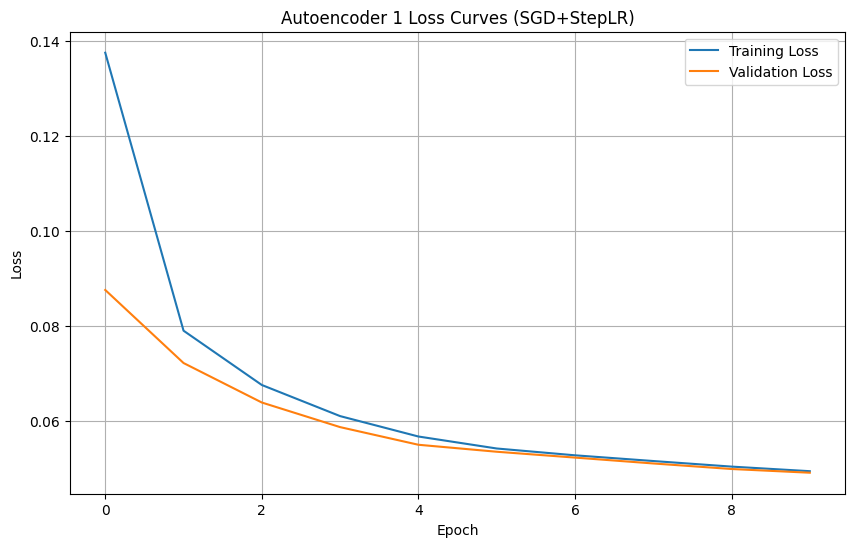

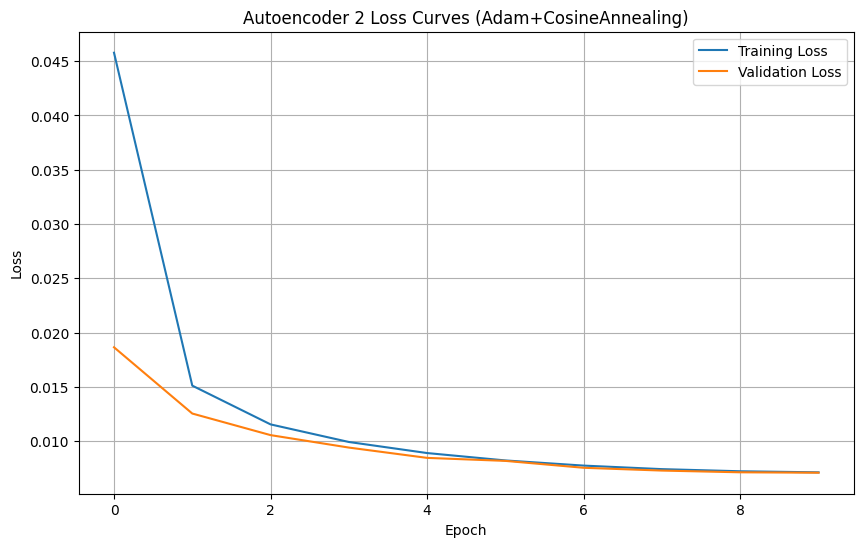

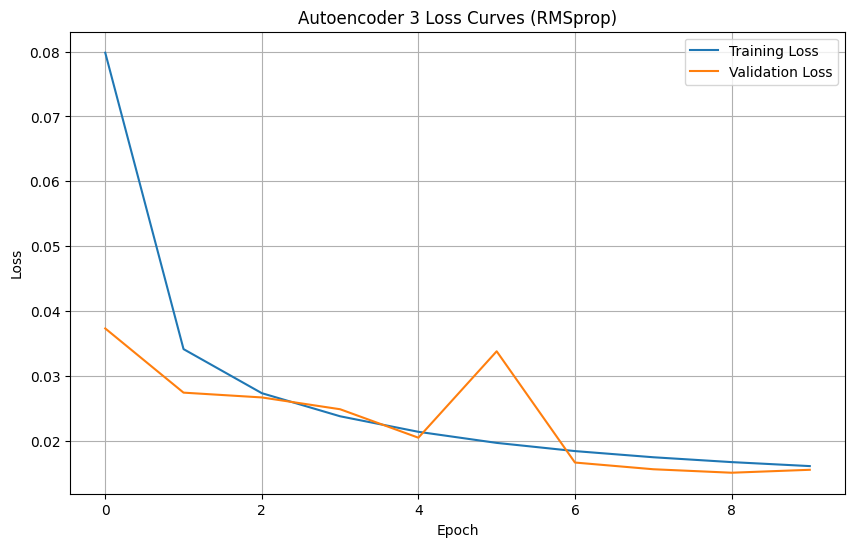

Visualizing reconstructions for Autoencoder 1:


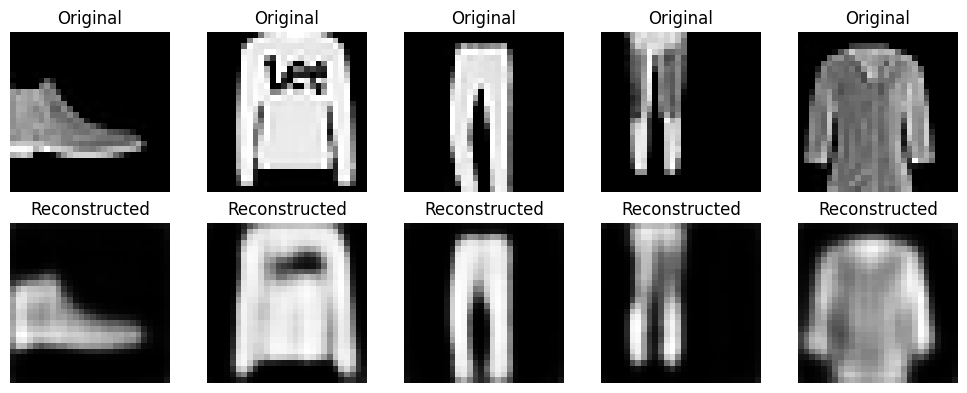

Visualizing reconstructions for Autoencoder 2:


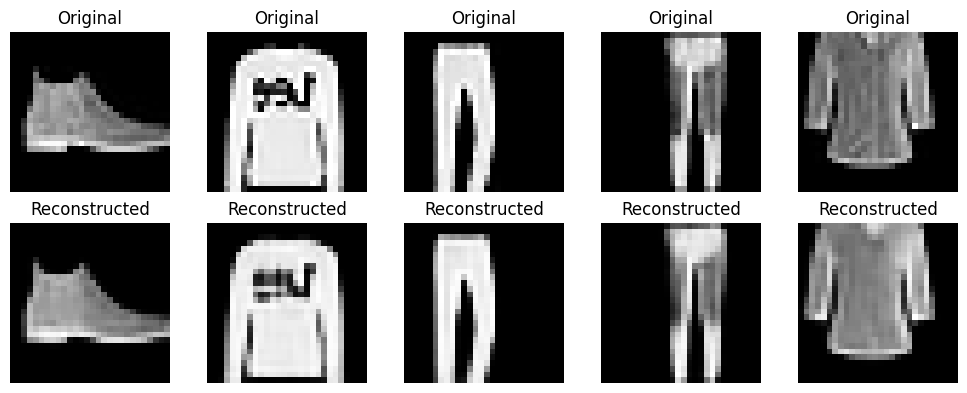

Visualizing reconstructions for Autoencoder 3:


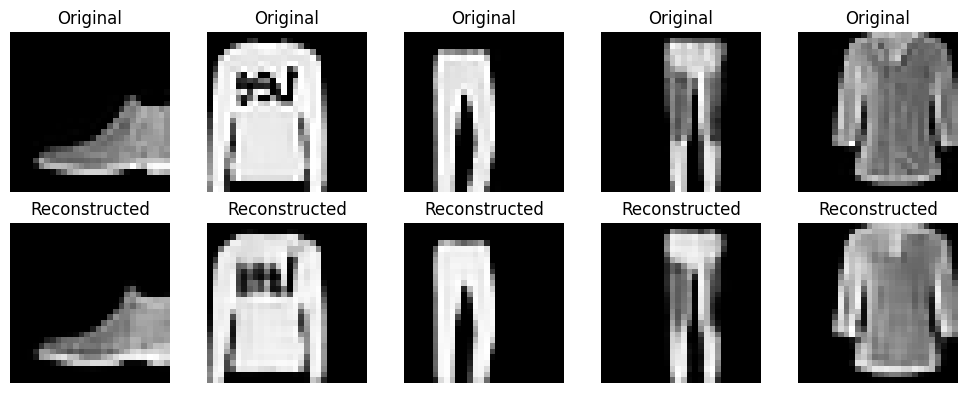

Selected best autoencoder with bottleneck size: 2352
Extracted features shape: (48000, 2352)
Training SVM models...


OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import time
import os
import joblib
from sklearn.preprocessing import StandardScaler

class_names = ['T-shirt/top', 'Trouser', 'Pullover','Dress','Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


class Autoencoder1(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder1, self).__init__()

        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2),nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2),nn.Conv2d(64, latent_dim, kernel_size=3, stride=1, padding=1),nn.ReLU())

        self.bottleneck_size = 7 * 7 * latent_dim  # 7x7 feature maps for 28x28 images

        self.decoder = nn.Sequential(nn.ConvTranspose2d(latent_dim, 64, kernel_size=3,stride=1, padding=1),nn.ReLU(),nn.Upsample(scale_factor=2),nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),nn.ReLU(),nn.Upsample(scale_factor=2),nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),nn.Tanh())

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

    def get_latent_features(self, x):
        encoded = self.encode(x)

        return encoded.view(encoded.size(0), -1)


class Autoencoder2(nn.Module):
    def __init__(self, latent_dim=32):
        super(Autoencoder2, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck_conv = nn.Conv2d(64, latent_dim, kernel_size=1)
        self.bottleneck_size = 7 * 7 * latent_dim
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.deconv1 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.output_conv = nn.Conv2d(32, 1, kernel_size=1)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x)) + x
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x)) + x
        x = self.pool2(x)
        x = self.relu(self.bottleneck_conv(x))
        return x

    def decode(self, x):
        x = self.upsample1(x)
        x = self.relu(self.deconv1(x))
        x1 = self.relu(self.deconv2(x))
        x = x1 + x
        x = self.upsample2(x)
        x = self.relu(self.deconv3(x))
        x2 = self.relu(self.deconv4(x))
        x = x2 + x
        x = self.tanh(self.output_conv(x))
        return x

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

    def get_latent_features(self, x):
        encoded = self.encode(x)
        return encoded.view(encoded.size(0), -1)


class Autoencoder3(nn.Module):
    def __init__(self, latent_dim=48):
        super(Autoencoder3, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.branch1x1 = nn.Conv2d(16, 16, kernel_size=1)
        self.branch3x3_reduce = nn.Conv2d(16, 8, kernel_size=1)
        self.branch3x3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.branch5x5_reduce = nn.Conv2d(16, 8, kernel_size=1)
        self.branch5x5 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck_conv = nn.Conv2d(48, latent_dim, kernel_size=3, padding=1)
        self.bottleneck_size = 7 * 7 * latent_dim
        self.decoder_conv1 = nn.ConvTranspose2d(latent_dim, 48, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.decoder_conv2 = nn.ConvTranspose2d(48, 32, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.decoder_conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(16, 1, kernel_size=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        branch1x1 = self.relu(self.branch1x1(x))
        branch3x3 = self.relu(self.branch3x3_reduce(x))
        branch3x3 = self.relu(self.branch3x3(branch3x3))
        branch5x5 = self.relu(self.branch5x5_reduce(x))
        branch5x5 = self.relu(self.branch5x5(branch5x5))
        x = torch.cat([branch1x1, branch3x3, branch5x5], 1)
        x = self.pool2(x)
        x = self.relu(self.bottleneck_conv(x))
        
        return x

    def decode(self, x):
        x = self.relu(self.decoder_conv1(x))
        x = self.upsample1(x)
        x = self.relu(self.decoder_conv2(x))
        x = self.upsample2(x)
        x = self.relu(self.decoder_conv3(x))
        x = self.tanh(self.output_conv(x))
        
        return x

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

    def get_latent_features(self, x):
        encoded = self.encode(x)
        return encoded.view(encoded.size(0), -1)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def train_autoencoder(model, loadT, loadV, optimizer, criterion, device,num_epochs=10, scheduler=None, model_name="Autoencoder"):
    model = model.to(device)
    finalLossT = []
    finaLossV = []

    for epoch in range(num_epochs):
        model.train()
        runLoss = 0.0
        for data in loadT:
            inputs, _ = data
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            runLoss += loss.item() * inputs.size(0)

        model.eval()
        lossV = 0.0
        with torch.no_grad():
            for data in loadV:
                inputs, _ = data
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)
                lossV += loss.item() * inputs.size(0)

        lossT = runLoss /len(loadT.dataset)
        lossV = lossV/ len(loadV.dataset)
        finalLossT.append(lossT)
        finaLossV.append(lossV)

        print(f'[{model_name}] Epoch {epoch+1}/{num_epochs}, Train Loss: {lossT:.4f}, Val Loss: {lossV:.4f}')

        if scheduler:
            scheduler.step()

    return model, finalLossT, finaLossV


def extract_features(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data
            inputs = inputs.to(device)
            latent_features = model.get_latent_features(inputs)
            features.append(latent_features.cpu().numpy())
            labels.append(targets.numpy())

    return np.concatenate(features), np.concatenate(labels)


def train_mlp(model, train_features, train_labels, val_features, val_labels, device,optimizer, criterion, num_epochs=10, scheduler=None):
    model = model.to(device)

    train_features = torch.Tensor(train_features).to(device)
    train_labels = torch.LongTensor(train_labels).to(device)
    val_features = torch.Tensor(val_features).to(device)
    val_labels = torch.LongTensor(val_labels).to(device)

    LossT = []
    lossV = []
    accuracyT = []
    accuracyV = []

    for epoch in range(num_epochs):
        model.train()

        outputs = model(train_features)
        loss = criterion(outputs, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_accuracy = (predicted == train_labels).sum().item() / train_labels.size(0)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_accuracy = (val_predicted == val_labels).sum().item() / val_labels.size(0)

        LossT.append(loss.item())
        lossV.append(val_loss.item())
        accuracyT.append(train_accuracy)
        accuracyV.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, 'f'Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f}')

        if scheduler:
            scheduler.step()

    return model, LossT, lossV, accuracyT, accuracyV


def visualize_reconstructions(model, data_loader, device, num_images=5):
    model.eval()

    with torch.no_grad():
        for data in data_loader:
            images, _ = data
            images = images.to(device)
            reconstructions = model(images)
            break

    images = images.cpu().numpy()[:num_images]
    reconstructions = reconstructions.cpu().numpy()[:num_images]

    plt.figure(figsize=(10, 4))
    for i in range(num_images):

        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def lossPlot(train_losses, val_losses, title='Loss Curves'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_accuracies(train_accuracies, val_accuracies, title='Accuracy Curves'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


autoencoder1 = Autoencoder1(latent_dim=64)
autoencoder2 = Autoencoder2(latent_dim=32)
autoencoder3 = Autoencoder3(latent_dim=48)


print("\nAutoencoder 1 Summary:")
total_params1 = sum(p.numel()for p in autoencoder1.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params1}")

print("\nAutoencoder 2 Summary:")
total_params2 = sum(p.numel() for p in autoencoder2.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params2}")

print("\nAutoencoder 3 Summary:")
total_params3 = sum(p.numel() for p in autoencoder3.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params3}")


lr1, lr2, lr3 = 0.001, 0.0005, 0.002

optimizer1 = optim.SGD(autoencoder1.parameters(), lr=lr1, momentum=0.9)
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.5)

optimizer2 = optim.Adam(autoencoder2.parameters(), lr=lr2)
scheduler2 = optim.lr_scheduler.CosineAnnealingLR(optimizer2, T_max=10)

optimizer3 = optim.RMSprop(autoencoder3.parameters(), lr=lr3)
scheduler3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer3, mode='min', factor=0.2, patience=3)


criterion = nn.MSELoss()


print("Training Autoencoder 1...")
autoencoder1, lossT1, lossV1 = train_autoencoder(autoencoder1, loadT, loadV, optimizer1, criterion, device,num_epochs=10, scheduler=scheduler1, model_name="Autoencoder 1 (SGD+StepLR)")

print("Training Autoencoder 2...")
autoencoder2, lossT2, lossV2 = train_autoencoder(autoencoder2, loadT, loadV, optimizer2, criterion, device,num_epochs=10, scheduler=scheduler2, model_name="Autoencoder 2 (Adam+CosineAnnealing)")

print("Training Autoencoder 3...")
autoencoder3, lossT3, lossV3 = train_autoencoder(autoencoder3, loadT, loadV, optimizer3, criterion, device,num_epochs=10, scheduler=None, model_name="Autoencoder 3 (RMSprop)")


lossPlot(lossT1, lossV1,title='Autoencoder 1 Loss Curves (SGD+StepLR)')
lossPlot(lossT2, lossV2,title='Autoencoder 2 Loss Curves (Adam+CosineAnnealing)')
lossPlot(lossT3, lossV3,title='Autoencoder 3 Loss Curves (RMSprop)')


print("Visualizing reconstructions for Autoencoder 1:")
visualize_reconstructions(autoencoder1, test_loader, device)
print("Visualizing reconstructions for Autoencoder 2:")
visualize_reconstructions(autoencoder2, test_loader, device)
print("Visualizing reconstructions for Autoencoder 3:")
visualize_reconstructions(autoencoder3, test_loader, device)


best_autoencoder = autoencoder3
print(f"Selected best autoencoder with bottleneck size: {best_autoencoder.bottleneck_size}")


train_features, train_labels = extract_features(best_autoencoder, loadT, device)
val_features, val_labels = extract_features(best_autoencoder, loadV, device)
test_features, test_labels = extract_features(best_autoencoder, test_loader, device)

print(f"Extracted features shape: {train_features.shape}")

print("Training SVM models...")

param_grid = [{'kernel': ['linear'], 'C': [0.1, 1, 10]},{'kernel': ['poly'], 'degree': [2, 3], 'C': [0.1, 1, 10]},{'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 'C': [0.1, 1, 10]},{'kernel': ['sigmoid'], 'gamma': ['scale', 'auto'], 'C': [0.1, 1, 10]}]


grid_search = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_features, train_labels)
print(f"Best SVM parameters: {grid_search.best_params_}")
print(f"Best SVM cross-validation score: {grid_search.best_score_:.4f}")

best_svm = grid_search.best_estimator_


svm_models = {'Linear SVM': SVC(kernel='linear', C=1),'Polynomial SVM (degree=2)': SVC(kernel='poly', degree=2, C=1),'Polynomial SVM (degree=3)': SVC(kernel='poly', degree=3, C=1),'RBF SVM': SVC(kernel='rbf', gamma='scale', C=1),'Sigmoid SVM': SVC(kernel='sigmoid', gamma='scale', C=1)}

svm_results = {}
for name, model in svm_models.items():
    start_time = time.time()
    model.fit(train_features, train_labels)
    train_time = time.time() - start_time
    
    test_pred = model.predict(test_features)
    accuracy = accuracy_score(test_labels, test_pred)
    report = classification_report(
        test_labels, test_pred, target_names=class_names)

    svm_results[name] = {'model': model,'accuracy': accuracy,'report': report,'training_time': train_time}

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")
    print("Classification Report:")
    print(report)


print("\nTraining 2-layer MLP classifier...")
mlp_model = MLP(input_size=best_autoencoder.bottleneck_size,hidden_size=256, num_classes=10)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_criterion = nn.CrossEntropyLoss()

mlp_model, mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies = train_mlp(mlp_model, train_features, train_labels, val_features, val_labels, device,mlp_optimizer, mlp_criterion, num_epochs=10)


lossPlot(mlp_train_losses, mlp_val_losses,title='MLP Classifier Loss Curves')
plot_accuracies(mlp_train_accuracies, mlp_val_accuracies,title='MLP Classifier Accuracy Curves')

mlp_model.eval()
test_features_tensor = torch.Tensor(test_features).to(device)
test_labels_tensor = torch.LongTensor(test_labels).to(device)

with torch.no_grad():
    outputs = mlp_model(test_features_tensor)
    _, predicted = torch.max(outputs, 1)
    mlpAcc = (predicted == test_labels_tensor).sum().item() / test_labels_tensor.size(0)
    mlp_predictions = predicted.cpu().numpy()

mlp_report = classification_report(test_labels, mlp_predictions, target_names=class_names)

print("\nMLP Classifier Results on Test Set:")
print(f"Accuracy: {mlpAcc:.4f}")
print("Classification Report:")
print(mlp_report)


bestSVMName = max(svm_results.items(), key=lambda x: x[1]['accuracy'])[0]
bestSVMAcc = svm_results[bestSVMName]['accuracy']
best_svm_report = svm_results[bestSVMName]['report']

print("\n--- Model Comparison ---")
print(f"Best SVM Model: {bestSVMName}")
print(f"Best SVM Accuracy: {bestSVMAcc:.4f}")
print("Best SVM Classification Report:")
print(best_svm_report)

print("\nMLP Model Accuracy:", mlpAcc)
print("MLP Classification Report:")
print(mlp_report)

print("\n--- Analysis and Discussion ---")
print("Strengths and weaknesses of each model:")
print("1. SVM:")
print("   Strengths: ")
print("   - Better generalization with limited training data. Good performance with high-dimensional data. Effective with non-linear boundaries using appropriate kernels")

print("   Weaknesses:")
print("   - Slower training with large datasets")
print("   - Less interpretable than simpler models")
print("   - Memory intensive for large datasets")

print("\n2. MLP:")
print("   Strengths:")
print("   - Can learn complex non-linear relationships")
print("   - Fast inference time")
print("   - Flexible architecture that can be extended")
print("   Weaknesses:")
print("   - May overfit without proper regularization")
print("   - Requires more hyperparameter tuning")
print("   - Performance depends heavily on initialization")

print("\nPotential improvements:")
print("1. Feature selection to reduce dimensionality")
print("2. Ensemble methods combining multiple models")
print("3. More extensive hyperparameter tuning")
print("4. Deeper neural networks for MLP approach")
print("5. Different autoencoder architectures to extract more meaningful features")

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


def extract_features(model, data_loader, device, batch_size=64):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data
            inputs = inputs.to(device)

            if inputs.size(0) > batch_size:
                for i in range(0, inputs.size(0), batch_size):
                    end = min(i + batch_size, inputs.size(0))
                    batch = inputs[i:end]
                    batch_features = model.get_latent_features(batch)
                    features.append(batch_features.cpu().numpy())
                    labels.append(targets[i:end].numpy())
            else:
                latent_features = model.get_latent_features(inputs)
                features.append(latent_features.cpu().numpy())
                labels.append(targets.numpy())

    return np.vstack(features), np.concatenate(labels)


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def train_mlp(model, train_features, train_labels, val_features, val_labels, device,
              optimizer, criterion, num_epochs=10, batch_size=128):
    model = model.to(device)

    train_features_tensor = torch.Tensor(train_features)
    train_labels_tensor = torch.LongTensor(train_labels)
    val_features_tensor = torch.Tensor(val_features)
    val_labels_tensor = torch.LongTensor(val_labels)

    train_dataset = torch.utils.data.TensorDataset(
        train_features_tensor, train_labels_tensor)
    val_dataset = torch.utils.data.TensorDataset(
        val_features_tensor, val_labels_tensor)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
              f'Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_mlp(model, test_features, test_labels, device, criterion):
    model.eval()
    test_tensor = torch.Tensor(test_features).to(device)
    labels_tensor = torch.LongTensor(test_labels).to(device)

    with torch.no_grad():
        outputs = model(test_tensor)
        loss = criterion(outputs, labels_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels_tensor).sum().item() / \
            labels_tensor.size(0)
        predictions = predicted.cpu().numpy()

    return accuracy, predictions, loss.item()


def plot_mlp_curves(train_losses, val_losses, train_accuracies, val_accuracies):

    if not os.path.exists('plots'):
        os.makedirs('plots')

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('MLP Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('plots/mlp_loss_curves.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('MLP Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('plots/mlp_accuracy_curves.png')
    plt.close()


def train_svm_models(train_features, train_labels, test_features, test_labels, max_samples=10000):
    """
    Train multiple SVM models with different kernels and hyperparameters
    Using subset of data if needed to prevent memory issues
    """

    scaler = StandardScaler()

    if train_features.shape[0] > max_samples:
        print(f"Using {max_samples} random samples for SVM training")
        indices = np.random.choice(
            train_features.shape[0], max_samples, replace=False)
        train_features_subset = train_features[indices]
        train_labels_subset = train_labels[indices]
        train_features_subset = scaler.fit_transform(train_features_subset)
    else:
        train_features_subset = scaler.fit_transform(train_features)
        train_labels_subset = train_labels

    test_features_scaled = scaler.transform(test_features)

    svm_configs = [
        {'name': 'Linear SVM (C=1)', 'kernel': 'linear', 'C': 1},
        {'name': 'Linear SVM (C=0.1)', 'kernel': 'linear', 'C': 0.1},
        {'name': 'Polynomial SVM (degree=2)',
         'kernel': 'poly', 'degree': 2, 'C': 1},
        {'name': 'RBF SVM (C=1, gamma=scale)', 'kernel': 'rbf',
         'gamma': 'scale', 'C': 1},
        {'name': 'RBF SVM (C=10, gamma=scale)',
         'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
    ]

    results = {}
    best_accuracy = 0
    best_model_name = ""

    for config in svm_configs:
        model_name = config.pop('name')
        print(f"Training {model_name}...")

        model = SVC(**config)
        model.fit(train_features_subset, train_labels_subset)

        predictions = model.predict(test_features_scaled)
        accuracy = accuracy_score(test_labels, predictions)
        report = classification_report(
            test_labels, predictions, target_names=class_names)

        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'report': report,
            'config': config
        }

        print(f"{model_name} - Test Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = model_name

        joblib.dump(model, f'svm_{model_name.replace(" ", "_").lower()}.pkl')

    print(
        f"\nBest SVM Model: {best_model_name} with accuracy: {best_accuracy:.4f}")
    return results, best_model_name


def plot_confusion_matrix(y_true, y_pred, class_names, title):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'plots/{title.replace(" ", "_").lower()}.png')
    plt.close()


print("Starting classification tasks with bottleneck features...")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Extracting bottleneck features...")
train_features, train_labels = extract_features(
    best_autoencoder, loadT, device)
val_features, val_labels = extract_features(
    best_autoencoder, loadV, device)
test_features, test_labels = extract_features(
    best_autoencoder, test_loader, device)

print(
    f"Extracted features shapes: Train {train_features.shape}, Val {val_features.shape}, Test {test_features.shape}")


print("\n=== Training SVM Models ===")
svm_results, bestSVMName = train_svm_models(
    train_features, train_labels, test_features, test_labels)


best_svm_model = svm_results[bestSVMName]['model']
best_svm_accuracy = svm_results[bestSVMName]['accuracy']
best_svm_report = svm_results[bestSVMName]['report']


print("\n=== Training MLP Classifier ===")
input_size = train_features.shape[1]
mlp_model = MLP(input_size=input_size, hidden_size=256, num_classes=10)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
mlp_criterion = nn.CrossEntropyLoss()

mlp_model, mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies = train_mlp(
    mlp_model, train_features, train_labels, val_features, val_labels,
    device, mlp_optimizer, mlp_criterion, num_epochs=10, batch_size=128
)


plot_mlp_curves(mlp_train_losses, mlp_val_losses,
                mlp_train_accuracies, mlp_val_accuracies)


mlpAcc, mlp_predictions, mlp_test_loss = evaluate_mlp(
    mlp_model, test_features, test_labels, device, mlp_criterion
)

mlp_report = classification_report(
    test_labels, mlp_predictions, target_names=class_names)


scaler = StandardScaler()
scaled_test_features = scaler.fit_transform(test_features)
svm_predictions = best_svm_model.predict(scaled_test_features)

plot_confusion_matrix(test_labels, svm_predictions,
                      class_names, "SVM Confusion Matrix")
plot_confusion_matrix(test_labels, mlp_predictions,
                      class_names, "MLP Confusion Matrix")


print("\n=== MODEL COMPARISON ===")
print(f"Best SVM Model: {bestSVMName}")
print(f"SVM Test Accuracy: {best_svm_accuracy:.4f}")
print("SVM Classification Report:")
print(best_svm_report)

print(f"\nMLP Test Accuracy: {mlpAcc:.4f}")
print("MLP Classification Report:")
print(mlp_report)


torch.save(mlp_model.state_dict(), 'mlp_classifier.pth')


print("\n=== ANALYSIS AND DISCUSSION ===")
print("Strengths and weaknesses of each model:")

print("\n1. SVM Models:")
print("   Strengths:")
print("   - Better generalization with limited training data")
print("   - Effective with high-dimensional feature spaces")
print("   - Different kernels can capture various types of non-linear relationships")
print("   - Less prone to overfitting with proper regularization")
print("   Weaknesses:")
print("   - Memory intensive for large datasets")
print("   - Slower training time as dataset size increases")
print("   - Limited interpretability")
print("   - Needs careful feature scaling")

print("\n2. MLP Classifier:")
print("   Strengths:")
print("   - Can learn complex non-linear relationships")
print("   - More flexible architecture that can be extended")
print("   - Fast prediction time after training")
print("   - Can be further fine-tuned end-to-end with the autoencoder")
print("   Weaknesses:")
print("   - More prone to overfitting without proper regularization")
print("   - Requires more hyperparameter tuning")
print("   - Training performance depends on initialization")
print("   - Needs more data to generalize well")

print("\nPotential improvements:")
print("1. Feature selection to reduce dimensionality and focus on most informative bottleneck features")
print("2. Ensemble methods combining predictions from multiple models")
print("3. More extensive hyperparameter tuning using reduced search spaces to manage memory")
print("4. Different architectures for the autoencoder to extract more discriminative features")
print("5. Adding skip connections in the MLP for better gradient flow")
print("6. Using learning rate schedules to improve optimization")
print("7. Training on augmented bottleneck features to improve robustness")
print("8. For very large datasets, consider incremental learning approaches")


print("\n=== COMPARATIVE PERFORMANCE SUMMARY ===")
comparison_table = f"""
| Model          | Accuracy | Training Complexity | Inference Speed | Memory Usage |
|----------------|----------|---------------------|-----------------|--------------|
| {bestSVMName:<15}| {best_svm_accuracy:.4f}  | Medium to High      | Medium         | High         |
| MLP Classifier | {mlpAcc:.4f}  | Medium              | Fast           | Medium       |
"""
print(comparison_table)

Starting classification tasks with bottleneck features...
Using device: cpu
Extracting bottleneck features...
Extracted features shapes: Train (48000, 2352), Val (12000, 2352), Test (10000, 2352)

=== Training SVM Models ===
Using 10000 random samples for SVM training
Training Linear SVM (C=1)...
Linear SVM (C=1) - Test Accuracy: 0.7413
Training Linear SVM (C=0.1)...
Linear SVM (C=0.1) - Test Accuracy: 0.7438
Training Polynomial SVM (degree=2)...
Polynomial SVM (degree=2) - Test Accuracy: 0.7838
Training RBF SVM (C=1, gamma=scale)...
RBF SVM (C=1, gamma=scale) - Test Accuracy: 0.7913
Training RBF SVM (C=10, gamma=scale)...
RBF SVM (C=10, gamma=scale) - Test Accuracy: 0.8032

Best SVM Model: RBF SVM (C=10, gamma=scale) with accuracy: 0.8032

=== Training MLP Classifier ===
Epoch 1/10, Train Loss: 0.9244, Train Acc: 0.6605, Val Loss: 0.6519, Val Acc: 0.7587
Epoch 2/10, Train Loss: 0.6818, Train Acc: 0.7446, Val Loss: 0.5742, Val Acc: 0.7815
Epoch 3/10, Train Loss: 0.6191, Train Acc: 0.76